# TF2 TimeGAN implementation
from https://github.com/jsyoon0823/TimeGAN/tree/master (arxiv: https://arxiv.org/pdf/2308.06663 )

In [2]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_absolute_error

In [3]:
###############################################################################
# 1) Data: sine generation, float32
###############################################################################

def sine_data_generation(n_samples=10000, seq_len=24, dim=5):
    """Generate n samples of random sine waves in [0,1]."""
    data = []
    for _ in range(n_samples):
        seq = []
        for _dim in range(dim):
            freq = np.random.uniform(0, 0.1)
            phase = np.random.uniform(0, 2*np.pi)
            x = [np.sin(freq*j + phase) for j in range(seq_len)]
            x = (np.array(x)+1)*0.5
            seq.append(x)
        seq = np.transpose(np.array(seq))
        data.append(seq)
    data = np.array(data).astype(np.float32)
    return data

In [4]:
###############################################################################
# 2) Utilities: batch generator, min-max scaling
###############################################################################

def batch_generator(data, batch_size):
    """
    Randomly samples a subset of data (batch_size)
    """
    idx = np.random.permutation(len(data))[:batch_size]
    return data[idx]

def min_max_scale(data):
    """
    Scale entire 3D array to [0,1].
    Returns scaled_data, min_val, max_val (all float32).
    """
    min_val = np.min(data, axis=(0,1), keepdims=True)
    data_ = data - min_val
    max_val = np.max(data_, axis=(0,1), keepdims=True)
    data_ = data_ / (max_val + 1e-7)
    return data_.astype(np.float32), min_val.astype(np.float32), max_val.astype(np.float32)

In [5]:
###############################################################################
# 3) Sub-networks
###############################################################################

# Embedder
class Embedder(tf.keras.Model):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.rnns = []
        for _ in range(num_layers):
            if rnn_type=='gru':
                self.rnns.append(layers.GRU(hidden_dim, return_sequences=True, activation='tanh'))
            else:
                self.rnns.append(layers.LSTM(hidden_dim, return_sequences=True, activation='tanh'))
        self.fc = layers.Dense(hidden_dim, activation='sigmoid')

    def call(self, x):
        h = x
        for rnn in self.rnns:
            h = rnn(h)
        return self.fc(h)

# Recovery
class Recovery(tf.keras.Model):
    def __init__(self, hidden_dim=24, out_dim=5, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.rnns = []
        for _ in range(num_layers):
            if rnn_type=='gru':
                self.rnns.append(layers.GRU(hidden_dim, return_sequences=True, activation='tanh'))
            else:
                self.rnns.append(layers.LSTM(hidden_dim, return_sequences=True, activation='tanh'))
        self.fc = layers.Dense(out_dim, activation='sigmoid')

    def call(self, h):
        x_ = h
        for rnn in self.rnns:
            x_ = rnn(x_)
        return self.fc(x_)

# Generator
class Generator(tf.keras.Model):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.rnns = []
        for _ in range(num_layers):
            if rnn_type=='gru':
                self.rnns.append(layers.GRU(hidden_dim, return_sequences=True, activation='tanh'))
            else:
                self.rnns.append(layers.LSTM(hidden_dim, return_sequences=True, activation='tanh'))
        self.fc = layers.Dense(hidden_dim, activation='sigmoid')

    def call(self, z):
        e = z
        for rnn in self.rnns:
            e = rnn(e)
        return self.fc(e)

# Supervisor
class Supervisor(tf.keras.Model):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.rnns = []
        for _ in range(num_layers-1):
            if rnn_type=='gru':
                self.rnns.append(layers.GRU(hidden_dim, return_sequences=True, activation='tanh'))
            else:
                self.rnns.append(layers.LSTM(hidden_dim, return_sequences=True, activation='tanh'))
        self.fc = layers.Dense(hidden_dim, activation='sigmoid')

    def call(self, h):
        s = h
        for rnn in self.rnns:
            s = rnn(s)
        return self.fc(s)

# Discriminator
class Discriminator(tf.keras.Model):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.rnns = []
        for _ in range(num_layers):
            if rnn_type=='gru':
                self.rnns.append(layers.GRU(hidden_dim, return_sequences=True, activation='tanh'))
            else:
                self.rnns.append(layers.LSTM(hidden_dim, return_sequences=True, activation='tanh'))
        self.fc = layers.Dense(1, activation=None)

    def call(self, h):
        d = h
        for rnn in self.rnns:
            d = rnn(d)
        return self.fc(d)

In [6]:
###############################################################################
# 4) TimeGAN
###############################################################################

class TimeGAN(tf.keras.Model):
    def __init__(self, seq_len, dim, hidden_dim=24, num_layers=3, module='gru', gamma=1.0):
        """
        Main TimeGAN model
        """
        super().__init__()
        self.seq_len = seq_len
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.module = module
        self.gamma = gamma

        # Create sub-models
        self.embedder = Embedder(hidden_dim, num_layers, module)
        self.recovery = Recovery(hidden_dim, dim, num_layers, module)
        self.generator = Generator(hidden_dim, num_layers, module)
        self.supervisor = Supervisor(hidden_dim, num_layers, module)
        self.discriminator = Discriminator(hidden_dim, num_layers, module)

        # Build submodules
        self._build_submodules()

        # After building submodules, create optimizers
        self.e_optimizer = tf.keras.optimizers.Adam()
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    def _build_submodules(self):
        # shape: (1, seq_len, dim)
        x_dummy = tf.zeros([1, self.seq_len, self.dim], dtype=tf.float32)
        z_dummy = tf.zeros([1, self.seq_len, self.dim], dtype=tf.float32)

        # pass through each sub-network once
        h = self.embedder(x_dummy)
        _ = self.recovery(h)
        e_hat = self.generator(z_dummy)
        h_hat = self.supervisor(e_hat)
        _ = self.discriminator(h_hat)

    @tf.function
    def train_embedder(self, x):
        """Phase 1: embedder/recovery MSE autoencoder loss."""
        with tf.GradientTape() as tape:
            h = self.embedder(x)
            x_tilde = self.recovery(h)
            e_mse = tf.reduce_mean(tf.square(x - x_tilde))
            e_loss = 10.0*tf.sqrt(e_mse)
        grads = tape.gradient(e_loss, self.embedder.trainable_variables + self.recovery.trainable_variables)
        self.e_optimizer.apply_gradients(zip(grads, self.embedder.trainable_variables + self.recovery.trainable_variables))
        return e_loss

    @tf.function
    def train_supervised(self, x):
        """Phase 2: supervised next-step prediction in latent space."""
        with tf.GradientTape() as tape:
            h = self.embedder(x)
            h_hat_sup = self.supervisor(h)
            s_mse = tf.reduce_mean(tf.square(h[:,1:,:] - h_hat_sup[:,:-1,:]))
        grads = tape.gradient(s_mse, self.generator.trainable_variables + self.supervisor.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables + self.supervisor.trainable_variables))
        return s_mse

    @tf.function
    def train_joint(self, x):
        """
        Phase 3: 2 generator updates, 1 discriminator update each step.
        """
        # Generator updates
        for _ in range(2):
            with tf.GradientTape() as tape_g:
                # Real
                h = self.embedder(x)
                x_tilde = self.recovery(h)

                # Fake
                z = tf.random.uniform([tf.shape(x)[0], self.seq_len, self.dim], dtype=tf.float32)
                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)

                h_hat_sup = self.supervisor(h)
                x_hat = self.recovery(h_hat)

                y_fake = self.discriminator(h_hat)
                y_fake_e = self.discriminator(e_hat)

                # G losses
                g_loss_u = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_fake, labels=tf.ones_like(y_fake)))
                g_loss_u_e = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_fake_e, labels=tf.ones_like(y_fake_e)))

                g_loss_s = tf.reduce_mean(tf.square(h[:,1:,:] - h_hat_sup[:,:-1,:]))

                x_mean, x_var = tf.nn.moments(x, axes=[0,1])
                x_hat_mean, x_hat_var = tf.nn.moments(x_hat, axes=[0,1])
                g_loss_v1 = tf.reduce_mean(tf.abs(tf.sqrt(x_hat_var+1e-6) - tf.sqrt(x_var+1e-6)))
                g_loss_v2 = tf.reduce_mean(tf.abs(x_hat_mean - x_mean))
                g_loss_v = g_loss_v1 + g_loss_v2

                # Generator Loss
                g_loss = g_loss_u + self.gamma*g_loss_u_e + 100*tf.sqrt(g_loss_s) + 100*g_loss_v

            grads_g = tape_g.gradient(g_loss, self.generator.trainable_variables + self.supervisor.trainable_variables)
            self.g_optimizer.apply_gradients(zip(grads_g, self.generator.trainable_variables + self.supervisor.trainable_variables))

            # Also update embedder a bit
            with tf.GradientTape() as tape_e:
                h2 = self.embedder(x)
                x_tilde2 = self.recovery(h2)
                e_mse = tf.reduce_mean(tf.square(x - x_tilde2))
                e_loss_0 = 10.0*tf.sqrt(e_mse)
                h_hat_sup2 = self.supervisor(h2)
                e_s_loss = tf.reduce_mean(tf.square(h2[:,1:,:] - h_hat_sup2[:,:-1,:]))
                e_loss = e_loss_0 + 0.1*e_s_loss

            grads_e = tape_e.gradient(e_loss, self.embedder.trainable_variables + self.recovery.trainable_variables)
            self.e_optimizer.apply_gradients(zip(grads_e, self.embedder.trainable_variables + self.recovery.trainable_variables))

        # Discriminator update
        with tf.GradientTape() as tape_d:
            h3 = self.embedder(x)
            z2 = tf.random.uniform([tf.shape(x)[0], self.seq_len, self.dim], dtype=tf.float32)
            e_hat2 = self.generator(z2)
            h_hat2 = self.supervisor(e_hat2)

            y_real = self.discriminator(h3)
            y_fake2 = self.discriminator(h_hat2)
            y_fake_e2 = self.discriminator(e_hat2)

            d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_real, labels=tf.ones_like(y_real)))
            d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_fake2, labels=tf.zeros_like(y_fake2)))
            d_loss_fake_e = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_fake_e2, labels=tf.zeros_like(y_fake_e2)))

            # Discriminator loss
            d_loss = d_loss_real + d_loss_fake + self.gamma*d_loss_fake_e

        grads_d = tape_d.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads_d, self.discriminator.trainable_variables))

        return g_loss, d_loss, e_loss

In [7]:
###############################################################################
# 5) Metrics: Discriminative & Predictive
###############################################################################

def posthoc_discriminative_score(ori_data, gen_data, epochs=1000, batch_size=128):
    """Train a simple RNN classifier to discriminate real vs. fake."""
    n_ori = len(ori_data)
    n_gen = len(gen_data)
    x_all = np.concatenate([ori_data, gen_data], axis=0)
    y_all = np.concatenate([np.ones(n_ori), np.zeros(n_gen)], axis=0)

    idx = np.random.permutation(len(x_all))
    x_all = x_all[idx]
    y_all = y_all[idx]

    split = int(0.8*len(x_all))
    x_train, x_test = x_all[:split], x_all[split:]
    y_train, y_test = y_all[:split], y_all[split:]

    model = tf.keras.Sequential([
        layers.Input(shape=(x_all.shape[1], x_all.shape[2])),
        layers.GRU(x_all.shape[2], activation='tanh'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    _, acc = model.evaluate(x_test, y_test, verbose=0)
    return abs(acc - 0.5)

def posthoc_predictive_score(ori_data, gen_data, epochs=1000, batch_size=128):
    """
    Train a 1-step-ahead predictor on the generated data, evaluate on original.
    Return MAE on original data.
    """
    def to_xy(data):
        X_ = data[:, :, :-1]
        Y_ = data[:, :, -1]
        return X_, Y_

    Xg, Yg = to_xy(gen_data)
    Xo, Yo = to_xy(ori_data)

    inputs = tf.keras.Input(shape=(Xg.shape[1], Xg.shape[2]))
    rnn = tf.keras.layers.GRU(64, return_sequences=True)(inputs)
    outputs = tf.keras.layers.Dense(1)(rnn)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')

    model.fit(Xg, Yg, epochs=epochs, batch_size=batch_size, verbose=0)
    pred = model.predict(Xo, verbose=0)  # (N, seq_len, 1)

    mae_list = []
    for i in range(len(Yo)):
        mae_list.append(mean_absolute_error(Yo[i], pred[i,:,0]))
    return np.mean(mae_list)

In [8]:

###############################################################################
# 6) Visualization (PCA, t-SNE)
###############################################################################

def visualize(ori_data, gen_data, method='pca', n_samples=1000):
    """
    Visualize the original and generated data using PCA or t-SNE.
    """
    idx = np.random.permutation(len(ori_data))[:min(n_samples, len(ori_data))]
    ori_samp = ori_data[idx]
    gen_samp = gen_data[idx]

    # Average across time
    ori_2d = np.mean(ori_samp, axis=1)
    gen_2d = np.mean(gen_samp, axis=1)
    combined = np.concatenate([ori_2d, gen_2d], axis=0)

    if method=='pca':
        pca = PCA(n_components=2)
        embed = pca.fit_transform(combined)
    else:
        tsne = TSNE(n_components=2, perplexity=40, max_iter=300, verbose=1)
        embed = tsne.fit_transform(combined)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,6))
    n_s = len(ori_2d)
    plt.scatter(embed[:n_s,0], embed[:n_s,1], alpha=0.5, label='Real')
    plt.scatter(embed[n_s:,0], embed[n_s:,1], alpha=0.5, label='Fake')
    plt.legend()
    plt.title(f'{method.upper()} Visualization')
    plt.show()

In [9]:
###############################################################################
# 7) Training Loop and Model Evaluation
###############################################################################

def run_timegan_tf2_sine(
    seq_len=24,
    dim=5,
    hidden_dim=24,
    num_layers=3,
    module='gru',
    gamma=1.0,
    iterations=2000,
    batch_size=128,
    metric_iterations=3,
    patience=20
):

    print("Generating Sine Data ...")
    ori_data = sine_data_generation(n_samples=10000, seq_len=seq_len, dim=dim)
    ori_data_scaled, min_val, max_val = min_max_scale(ori_data)

    # Build TimeGAN (pre-build sub-networks)
    timegan_model = TimeGAN(seq_len, dim, hidden_dim, num_layers, module, gamma)

    ############################################################################
    # Phase 1: Embedding network training
    ############################################################################
    print("Phase 1: Embedding network training ...")

    # For Early Stopping
    best_e_loss = float('inf')
    no_improve_steps_e = 0

    # Training Loop
    for step in range(iterations):
        x_mb = batch_generator(ori_data_scaled, batch_size)
        e_loss = timegan_model.train_embedder(x_mb)

        # Early stopping logic for Phase 1
        current_loss = e_loss.numpy()
        if current_loss < best_e_loss:
            best_e_loss = current_loss
            no_improve_steps_e = 0
        else:
            no_improve_steps_e += 1

        # Print embedding loss every 100 steps
        if (step+1) % 100 == 0:
            print(f" Step {step+1}/{iterations} | E_loss: {current_loss:.4f}")

        if no_improve_steps_e >= patience:
            print(f"Early stopping triggered in Phase 1 at step {step+1} | E_loss: {current_loss:.4f}")
            break

    ############################################################################
    # Phase 1.1: Plotting Reconstruction Error
    ############################################################################

    # Suppose x_mb is a small batch of shape (batch_size, seq_len, dim)
    x_mb = ori_data_scaled[:2]

    # Get hidden representation
    h_mb = timegan_model.embedder(x_mb)

    # Reconstruct
    x_tilde_mb = timegan_model.recovery(h_mb)

    recon_error = tf.reduce_mean(tf.square(x_mb - x_tilde_mb)).numpy()
    print("Reconstruction error after Phase 1:", recon_error)

    # Plot side by side for 1 sample
    import matplotlib.pyplot as plt

    def plot_reconstruction_comparison(x_real, x_recon):
        seq_len, dim = x_real.shape
        fig, axs = plt.subplots(dim, 1, figsize=(6, 2*dim))
        for d in range(dim):
            axs[d].plot(x_real[:, d], label="Real", color='blue')
            axs[d].plot(x_recon[:, d], label="Reconstructed", color='red', linestyle='--')
            axs[d].set_title(f"Dimension {d}")
            axs[d].legend()
        plt.tight_layout()
        plt.show()

    plot_reconstruction_comparison(x_mb[0], x_tilde_mb[0])

    ############################################################################
    # Phase 2: Supervised loss training
    ############################################################################

    print("Phase 2: Supervised loss training ...")

    best_s_loss = float('inf')
    no_improve_steps_s = 0

    for step in range(iterations):
        x_mb = batch_generator(ori_data_scaled, batch_size)
        s_loss = timegan_model.train_supervised(x_mb)

        # Early stopping logic for Phase 2
        current_loss = s_loss.numpy()
        if current_loss < best_s_loss:
            best_s_loss = current_loss
            no_improve_steps_s = 0
        else:
            no_improve_steps_s += 1

        if (step+1) % 100 == 0:
            print(f" Step {step+1}/{iterations} | S_loss: {current_loss:.4f}")

        if no_improve_steps_s >= patience:
            print(f"Early stopping triggered in Phase 2 at step {step+1} | S_loss: {current_loss:.4f}")
            break

    ############################################################################
    # Phase 2.1: Print Supervisor Error
    ############################################################################

    h_mb = timegan_model.embedder(ori_data_scaled[:2])
    h_hat_sup = timegan_model.supervisor(h_mb)
    sup_error = tf.reduce_mean(tf.square(h_mb[:,1:,:] - h_hat_sup[:,:-1,:])).numpy()
    print("Supervisor next-step error after Phase 2:", sup_error)

    ############################################################################
    # Phase 3: Joint training
    ############################################################################
    print("Phase 3: Joint training (2 G updates, 1 D update per iteration) ...")

    # For loss plotting
    g_losses, d_losses, e_losses = [], [], []

    # Training loop
    for step in range(iterations):
        x_mb = batch_generator(ori_data_scaled, batch_size)
        g_loss, d_loss, e_loss_val = timegan_model.train_joint(x_mb)

        # Append losses
        g_losses.append(g_loss.numpy())
        d_losses.append(d_loss.numpy())
        e_losses.append(e_loss_val.numpy())

        if (step+1) % 100 == 0:
            print(f" Step {step+1}/{iterations} | G_loss: {g_loss.numpy():.4f}"
                  f" | D_loss: {d_loss.numpy():.4f} | E_loss: {e_loss_val.numpy():.4f}")

    ############################################################################
    # Phase 3.1: Plotting Joint Training Losses
    ############################################################################

    # Plotting losses
    plt.figure(figsize=(10,4))
    plt.plot(g_losses, label="G_loss")
    plt.plot(d_losses, label="D_loss")
    plt.plot(e_losses, label="E_loss (Phase 3)")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Joint Phase Loss Curves")
    plt.show()

    # Plot random generated samples; compare to real mean std
    n_samples = len(ori_data_scaled)
    z = tf.random.uniform([n_samples, timegan_model.seq_len, timegan_model.dim], dtype=tf.float32)
    g_out = timegan_model.generator(z)
    h_hat = timegan_model.supervisor(g_out)
    x_hat = timegan_model.recovery(h_hat).numpy()

    x_hat_rescaled = x_hat * (max_val + 1e-7) + min_val

    for i in range(3):  # plot just 3 random samples
      idx = np.random.randint(0, n_samples)
      plt.figure()
      plt.plot(x_hat_rescaled[idx, :, 0], label="Fake Dim 0")
      plt.plot(x_hat_rescaled[idx, :, 1], label="Fake Dim 1")
      plt.title(f"Fake Sample {idx}")
      plt.legend()
      plt.show()

    real_mean = np.mean(ori_data, axis=(0,1))
    real_std = np.std(ori_data, axis=(0,1))

    fake_mean = np.mean(x_hat_rescaled, axis=(0,1))
    fake_std = np.std(x_hat_rescaled, axis=(0,1))

    print("Real mean:", real_mean)
    print("Fake mean:", fake_mean)
    print("Real std:", real_std)
    print("Fake std:", fake_std)

    ############################################################################
    # Phase 4: Evaluating Model
    ############################################################################

    print("Generating synthetic data ...")
    n_samples = len(ori_data_scaled)
    z = np.random.uniform(0,1,(n_samples, seq_len, dim)).astype(np.float32)
    e_hat = timegan_model.generator(z)
    h_hat = timegan_model.supervisor(e_hat)
    x_hat = timegan_model.recovery(h_hat).numpy()

    # Denormalize
    x_hat_rescaled = x_hat*(max_val+1e-7) + min_val

    print("Computing metrics ...")
    disc_scores = []
    pred_scores = []
    for _ in range(metric_iterations):
        disc = posthoc_discriminative_score(ori_data, x_hat_rescaled, epochs=5)
        pred = posthoc_predictive_score(ori_data, x_hat_rescaled, epochs=5)
        disc_scores.append(disc)
        pred_scores.append(pred)
    disc_mean = np.mean(disc_scores)
    pred_mean = np.mean(pred_scores)

    print(f"Discriminative Score: {disc_mean:.4f}")
    print(f"Predictive Score   : {pred_mean:.4f}")

    print("Visualizing with PCA ...")
    visualize(ori_data, x_hat_rescaled, method='pca')
    print("Visualizing with t-SNE ...")
    visualize(ori_data, x_hat_rescaled, method='tsne')

    return ori_data, x_hat_rescaled, disc_mean, pred_mean

Running TimeGAN TF2 with sub-network pre-building ...
Generating Sine Data ...
Phase 1: Embedding network training ...
 Step 100/10000 | E_loss: 0.7128
 Step 200/10000 | E_loss: 0.5034
 Step 300/10000 | E_loss: 0.3480
 Step 400/10000 | E_loss: 0.2500
 Step 500/10000 | E_loss: 0.2016
 Step 600/10000 | E_loss: 0.1743
 Step 700/10000 | E_loss: 0.1714
 Step 800/10000 | E_loss: 0.1458
 Step 900/10000 | E_loss: 0.1352
 Step 1000/10000 | E_loss: 0.1212
Early stopping triggered in Phase 1 at step 1093 | E_loss: 0.1276
Reconstruction error after Phase 1: 0.00013640967


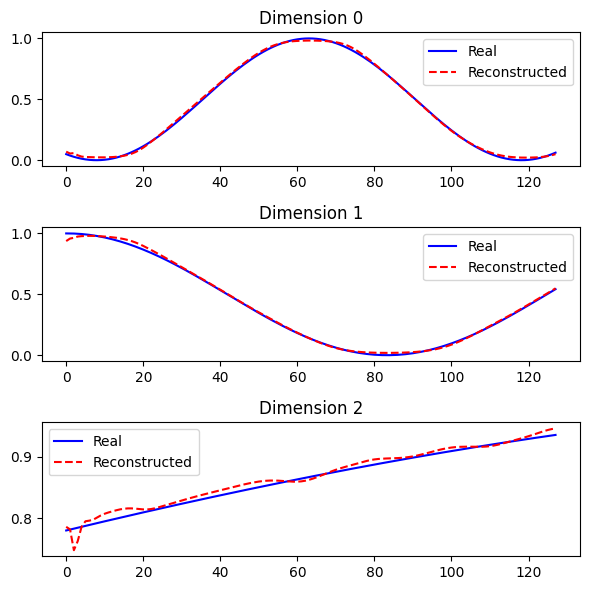

Phase 2: Supervised loss training ...


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


 Step 100/10000 | S_loss: 0.0206
 Step 200/10000 | S_loss: 0.0156
 Step 300/10000 | S_loss: 0.0121
 Step 400/10000 | S_loss: 0.0083
 Step 500/10000 | S_loss: 0.0053
 Step 600/10000 | S_loss: 0.0028
 Step 700/10000 | S_loss: 0.0020
 Step 800/10000 | S_loss: 0.0015
 Step 900/10000 | S_loss: 0.0013
 Step 1000/10000 | S_loss: 0.0011
 Step 1100/10000 | S_loss: 0.0010
 Step 1200/10000 | S_loss: 0.0008
 Step 1300/10000 | S_loss: 0.0007
 Step 1400/10000 | S_loss: 0.0007
 Step 1500/10000 | S_loss: 0.0006
 Step 1600/10000 | S_loss: 0.0006
 Step 1700/10000 | S_loss: 0.0005
 Step 1800/10000 | S_loss: 0.0005
 Step 1900/10000 | S_loss: 0.0004
 Step 2000/10000 | S_loss: 0.0004
 Step 2100/10000 | S_loss: 0.0004
 Step 2200/10000 | S_loss: 0.0003
 Step 2300/10000 | S_loss: 0.0003
 Step 2400/10000 | S_loss: 0.0003
 Step 2500/10000 | S_loss: 0.0003
 Step 2600/10000 | S_loss: 0.0003
 Step 2700/10000 | S_loss: 0.0002
 Step 2800/10000 | S_loss: 0.0002
 Step 2900/10000 | S_loss: 0.0002
 Step 3000/10000 | S_lo

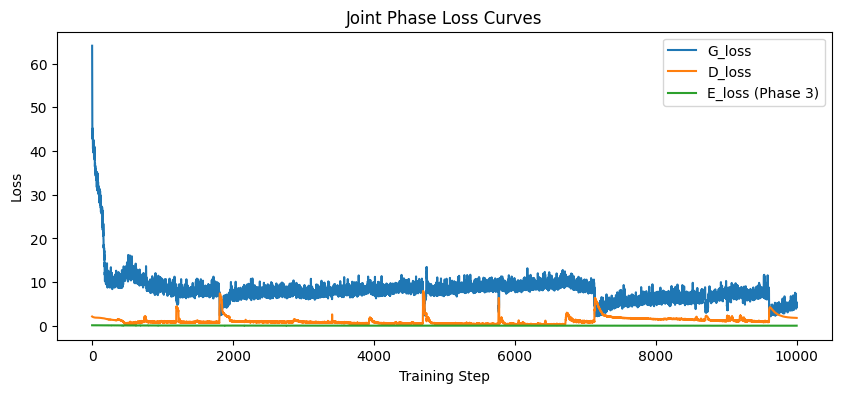

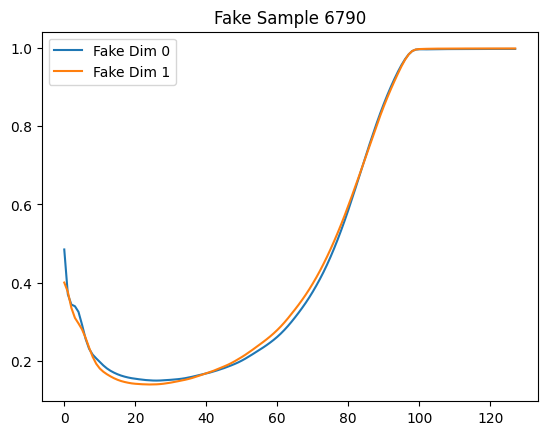

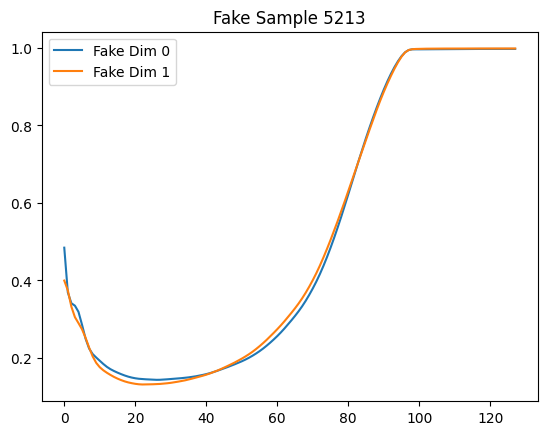

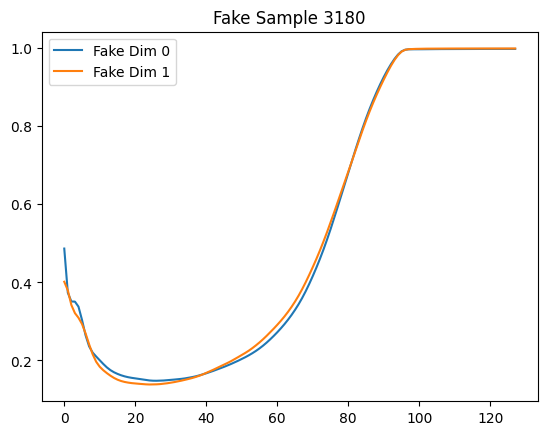

Real mean: [0.49984992 0.5003872  0.50151175]
Fake mean: [0.49949506 0.49940664 0.503091  ]
Real std: [0.3543765  0.35405678 0.35378549]
Fake std: [0.35100374 0.3516215  0.35602885]
Generating synthetic data ...
Computing metrics ...
Discriminative Score: 0.4856
Predictive Score   : 0.3679
Visualizing with PCA ...


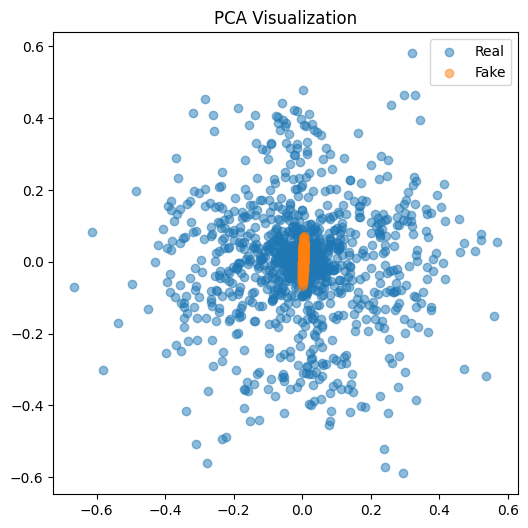

Visualizing with t-SNE ...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.001893
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.055511
[t-SNE] KL divergence after 300 iterations: 1.106228


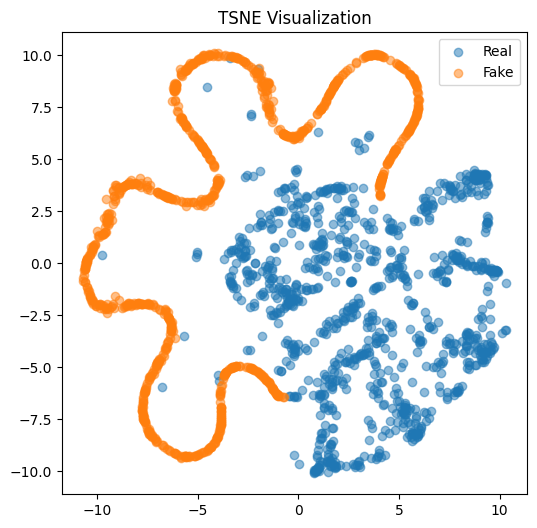

Done!


In [13]:
###############################################################################
# 8) Runs the TimeGAN
###############################################################################
if __name__ == "__main__":
    print("Running TimeGAN TF2 with sub-network pre-building ...")
    ori_data, gen_data, disc_score, pred_score = run_timegan_tf2_sine(
        seq_len=128,
        dim=3,
        hidden_dim=32,
        num_layers=3,
        module='gru', #gru, lstm
        gamma=1.0,
        iterations=10000,
        batch_size=128,
        metric_iterations=5,
        patience=64
    )
    print("Done!")

In [14]:
###############################################################################
# 9) Visualize Real vs. Fake Data
###############################################################################

def visualize_samples(ori_data, gen_data, n_samples=5, dimension=0):
    """
    Randomly picks `n_samples` from ori_data and gen_data,
    and plots them over time for one chosen dimension.
    """
    # Randomly choose real and fake data
    idx_real = np.random.choice(len(ori_data), size=n_samples, replace=False)
    idx_fake = np.random.choice(len(gen_data), size=n_samples, replace=False)

    plt.figure(figsize=(10, 6))

    # Plot real data samples
    for i in idx_real:
        plt.plot(ori_data[i, :, dimension], color='blue', alpha=0.5)

    # Plot fake data samples
    for j in idx_fake:
        plt.plot(gen_data[j, :, dimension], color='red', alpha=0.5)

    plt.title(f"Overlay of {n_samples} Real (blue) vs. {n_samples} Fake (red) Samples (Dim={dimension})")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

Visualizing data samples ...


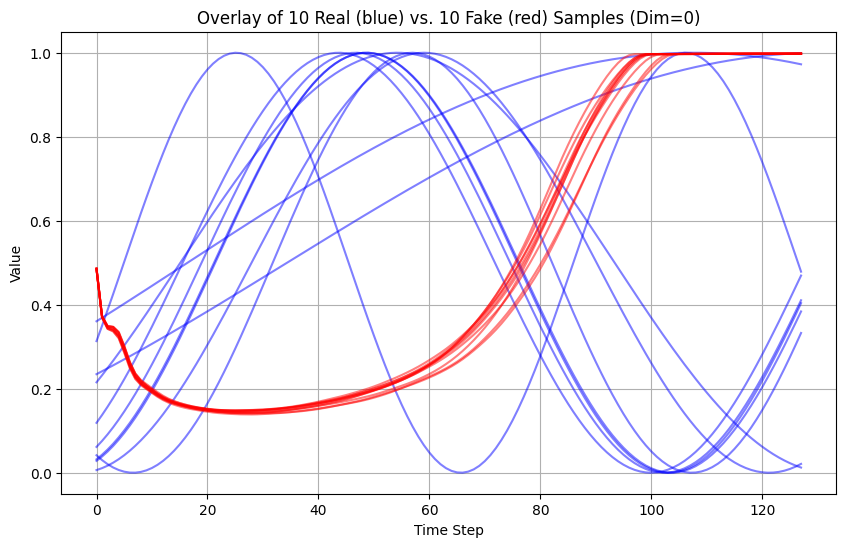

In [15]:
###############################################################################
# 10) Runs Data Visualization
###############################################################################
if __name__ == "__main__":
    print("Visualizing data samples ...")
    visualize_samples(ori_data, gen_data, n_samples=10, dimension=0)